In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [15]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [16]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [17]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [18]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [19]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [20]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [21]:
X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]


y_test  =org_test_processed[target]
X_test  =org_test_processed[features]

In [22]:
import torch
import torch.nn as nn
import numpy as np

# ------------------ TimesNet Model ------------------

class TimesBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (1, kernel_size), dilation=(1, dilation), padding=(0, dilation * (kernel_size - 1) // 2))
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm(out)
        out = self.relu(out)
        return out

class TimesNet(nn.Module):
    def __init__(self, input_len, forecast_len, num_features, hidden_channels=64, num_blocks=3, kernel_size=3):
        super().__init__()
        self.input_len = input_len
        self.forecast_len = forecast_len
        self.num_features = num_features

        self.blocks = nn.ModuleList()
        in_channels = 1

        for i in range(num_blocks):
            block = TimesBlock(in_channels, hidden_channels, kernel_size, dilation=2**i)
            self.blocks.append(block)
            in_channels = hidden_channels

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, forecast_len)

    def forward(self, x):
        # Input shape: [Batch, Seq_len, Num_features]
        x = x.unsqueeze(1)  # [Batch, 1, Seq_len, Num_features] -> like an image
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1).squeeze(-1)
        out = self.fc(x)
        return out


In [23]:
# ------------------ Sequence Creation ------------------

def create_timesnet_multivariate_sequences(X_data, y_data, input_len, forecast_len):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - input_len - forecast_len + 1):
        X_seq.append(X_data[i:i+input_len])
        y_seq.append(y_data[i+input_len:i+input_len+forecast_len])
    return np.array(X_seq), np.array(y_seq)


In [24]:
# Desequencing Function
def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast


In [46]:
input_len = 24
forecast_len = 12
num_features = X_train_org.shape[1]


In [47]:
model_timesnet_org = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)
model_timesnet_aug = TimesNet(input_len=input_len, forecast_len=forecast_len, num_features=num_features)


In [48]:
# Load checkpoint
checkpoint_org = torch.load("../Models/weights/timesnet_org_shuffle.pth")
checkpoint_aug = torch.load("../Models/weights/timesnet_aug_shuffle.pth")

# Extract only the model state
model_timesnet_org.load_state_dict(checkpoint_org['model_state'])
model_timesnet_aug.load_state_dict(checkpoint_aug['model_state'])

<All keys matched successfully>

In [54]:
# ------------------ Desequencing ------------------

def desequence_forecasts(predictions, input_len, forecast_len):
    total_length = len(predictions) + input_len + forecast_len - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start = i + input_len
        end = start + forecast_len
        merged_forecast[start:end] += predictions[i]
        count[start:end] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]
    return merged_forecast

# ------------------ Evaluation ------------------

import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_timesnet_multivariate(model, scaler_X, scaler_y, X_test, y_test, input_len, forecast_len, time_index=None, start_point=0, end_point=None):
    X_test = X_test[start_point:end_point]
    y_test = y_test[start_point:end_point]

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        preds_scaled = model(X_tensor).numpy()

    preds = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).reshape(preds_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    merged_pred = desequence_forecasts(preds, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    merged_pred = merged_pred
    merged_true = merged_true

    mse = mean_squared_error(merged_true, merged_pred)
    mae = mean_absolute_error(merged_true, merged_pred)
    rmse = math.sqrt(mse)
    print(f"Test MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    if time_index is not None:
        valid_time_index = time_index[input_len+forecast_len:][:len(merged_pred)]
    else:
        valid_time_index = range(len(merged_pred))

    plt.figure(figsize=(16, 6))
    plt.plot(valid_time_index, merged_true, label="Actual", color="black")
    plt.plot(valid_time_index, merged_pred, label="Forecast", color="red", linestyle="--")
    plt.xlabel("Time" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    textstr = f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}'
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


In [ ]:
# Evaluate
print("\nEvaluating TimesNet...")
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=7991, end_point=8734)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=16726, end_point=17469)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=25461, end_point=26204)
evaluate_timesnet_multivariate(model_timesnet_aug, scaler_X_timesne_aug, scaler_y_timesnet_aug, X_test, y_test, input_len, forecast_len, start_point=34196, end_point=34939)


In [65]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import torch
import numpy as np
import math

def evaluate_two_timesnet_models(
    model_org, model_aug,
    X_train_org, y_train_org,
    X_test, y_test,
    input_len, forecast_len,
    start_point=0, end_point=None
):
    # ----------------- Step 1: Scaling -----------------
    scaler_X = StandardScaler()
    scaler_X.fit(X_train_org)

    scaler_y = StandardScaler()
    scaler_y.fit(y_train_org.values.reshape(-1, 1))

    # ----------------- Step 2: Slice test set -----------------
    X_test = X_test[start_point:end_point].reset_index(drop=True)
    y_test = y_test[start_point:end_point].reset_index(drop=True)

    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # ----------------- Step 3: Sequence creation -----------------
    X_seq, y_seq = create_timesnet_multivariate_sequences(X_test_scaled, y_test_scaled, input_len, forecast_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)

    # ----------------- Step 4: Prediction -----------------
    model_org.eval()
    model_aug.eval()
    with torch.no_grad():
        preds_org_scaled = model_org(X_tensor).numpy()
        preds_aug_scaled = model_aug(X_tensor).numpy()

    # ----------------- Step 5: Inverse scale predictions and targets -----------------
    preds_org = scaler_y.inverse_transform(preds_org_scaled.reshape(-1, 1)).reshape(preds_org_scaled.shape)
    preds_aug = scaler_y.inverse_transform(preds_aug_scaled.reshape(-1, 1)).reshape(preds_aug_scaled.shape)
    y_true = scaler_y.inverse_transform(y_seq.reshape(-1, 1)).reshape(y_seq.shape)

    # ----------------- Step 6: Desequencing -----------------
    merged_pred_org = desequence_forecasts(preds_org, input_len, forecast_len)
    merged_pred_aug = desequence_forecasts(preds_aug, input_len, forecast_len)
    merged_true = desequence_forecasts(y_true, input_len, forecast_len)

    # Align lengths
    min_len = min(len(merged_pred_org), len(merged_pred_aug), len(merged_true))
    merged_pred_org = merged_pred_org[:min_len]
    merged_pred_aug = merged_pred_aug[:min_len]
    merged_true = merged_true[:min_len]

    # ----------------- Step 7: Metrics -----------------
    mse_org = mean_squared_error(merged_true, merged_pred_org)
    mae_org = mean_absolute_error(merged_true, merged_pred_org)
    rmse_org = math.sqrt(mse_org)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"[Original]  MAE: {mae_org:.4f}, RMSE: {rmse_org:.4f}")
    print(f"[Augmented] MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    # ----------------- Step 8: Plotting -----------------
    plot_range = range(min_len)

    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black')
    plt.plot(plot_range, merged_pred_org, label='Original Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='Augmented Forecast', color='green', linestyle=':')

    plt.fill_between(plot_range, merged_pred_org, merged_pred_aug,
                     where=(merged_pred_aug >= merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.5, label='Diff (Aug > Org)')
    plt.fill_between(plot_range, merged_pred_aug, merged_pred_org,
                     where=(merged_pred_aug < merged_pred_org),
                     interpolate=True, color='lightblue', alpha=0.5)

    plt.xlabel("Steps")
    plt.ylabel("Power")
    plt.title("TimesNet Forecast Comparison: Original vs Augmented")
    plt.legend()
    plt.grid(True)

    textstr = (
        f'Original Model\nMAE: {mae_org:.4f}\nRMSE: {rmse_org:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    # plt.show()

    #     # --- Inset Zoom Plot ---
    # # Define zoom window (adjust indices for a peak region)
    # zoom_start, zoom_end = 200, 300

    # ax_main = plt.gca()
    # ax_inset = inset_axes(ax_main, width="30%", height="40%", loc='upper left', borderpad=3)
    # ax_inset.plot(range(zoom_start, zoom_end), merged_true[zoom_start:zoom_end], color='black')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_org[zoom_start:zoom_end], color='red', linestyle='--')
    # ax_inset.plot(range(zoom_start, zoom_end), merged_pred_aug[zoom_start:zoom_end], color='green', linestyle=':')

    # ax_inset.set_title("Zoomed-In View")
    # ax_inset.grid(True)
    # ax_inset.tick_params(axis='both', labelsize=8)

    # mark_inset(ax_main, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()

    return {
        'Original': {'MAE': mae_org, 'RMSE': rmse_org},
        'Augmented': {'MAE': mae_aug, 'RMSE': rmse_aug}
    }


[Original]  MAE: 0.2465, RMSE: 0.3036
[Augmented] MAE: 0.2685, RMSE: 0.3270


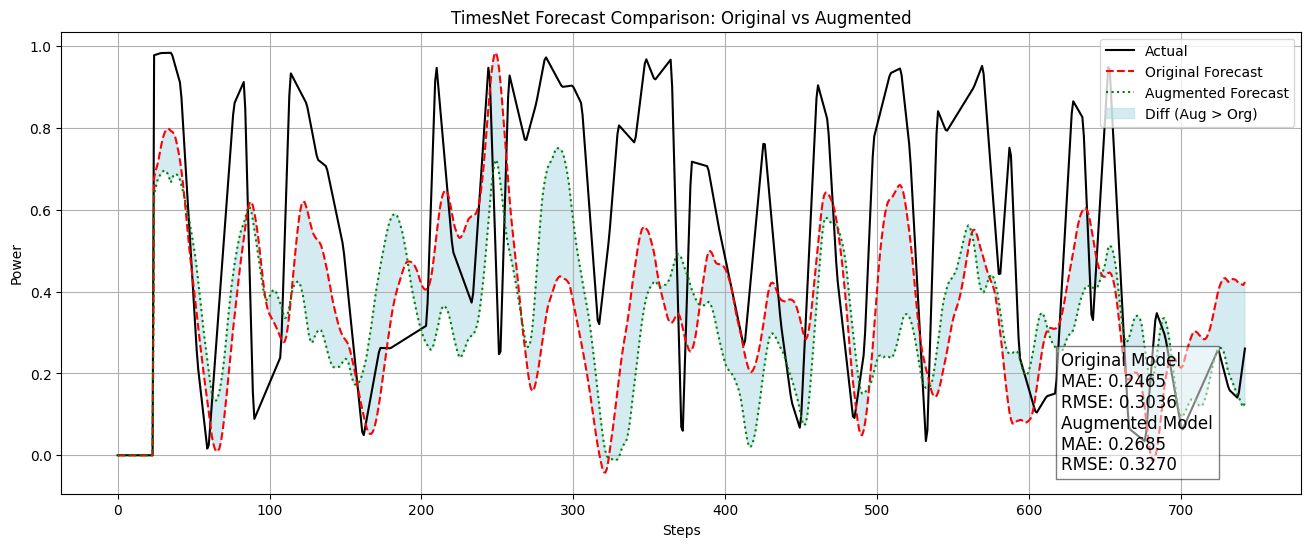

[Original]  MAE: 0.1405, RMSE: 0.1876
[Augmented] MAE: 0.1412, RMSE: 0.1884


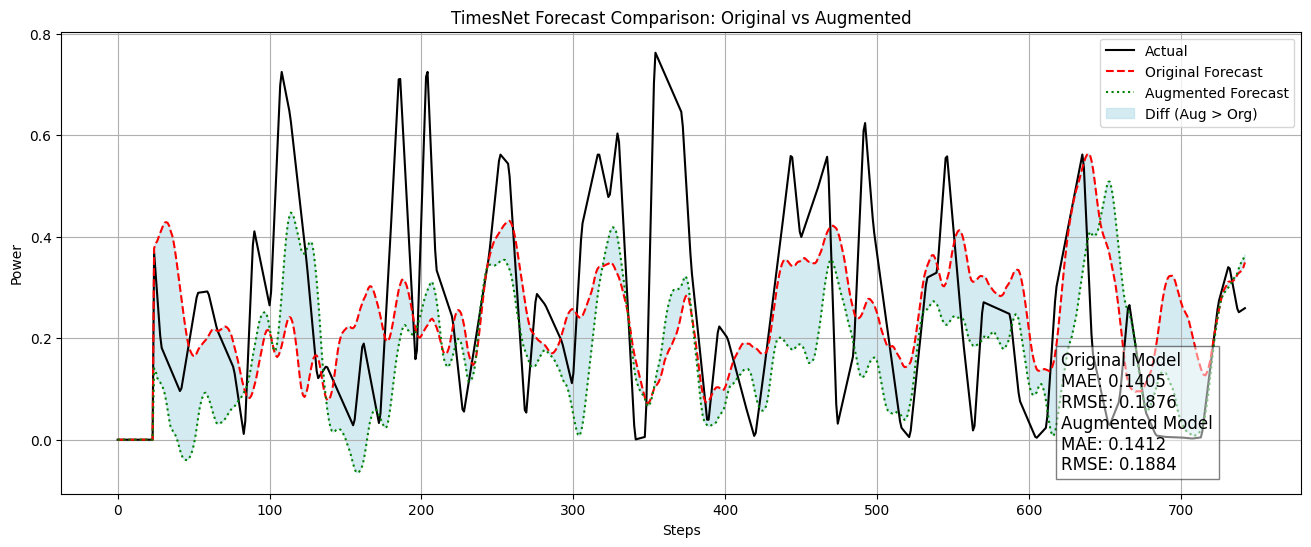

[Original]  MAE: 0.2940, RMSE: 0.3598
[Augmented] MAE: 0.3081, RMSE: 0.3638


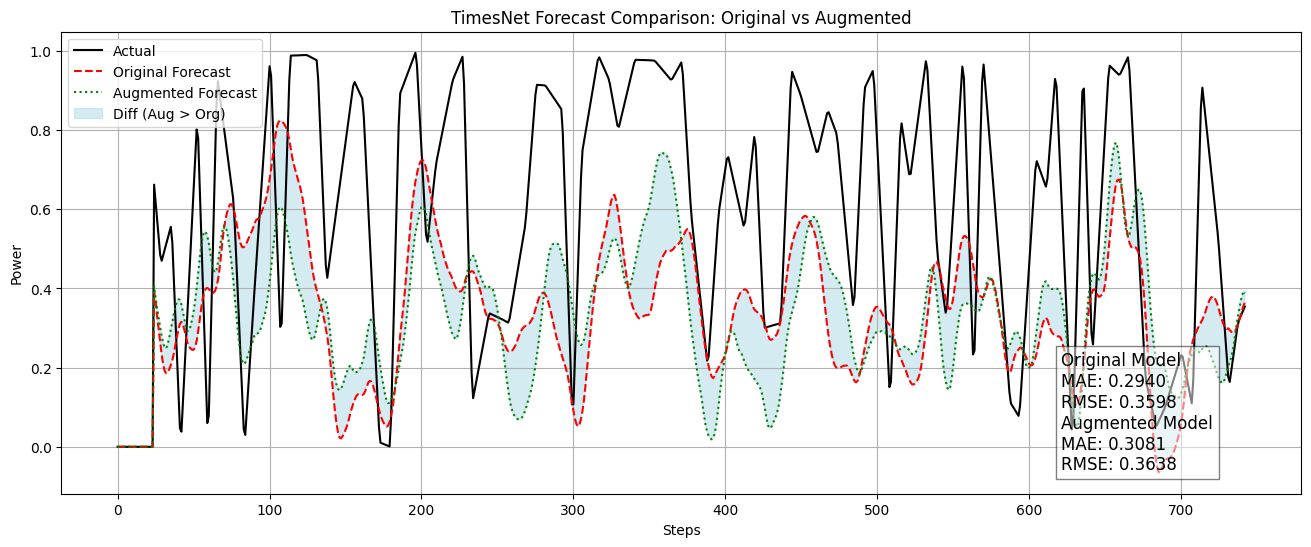

[Original]  MAE: 0.1750, RMSE: 0.2134
[Augmented] MAE: 0.1846, RMSE: 0.2431


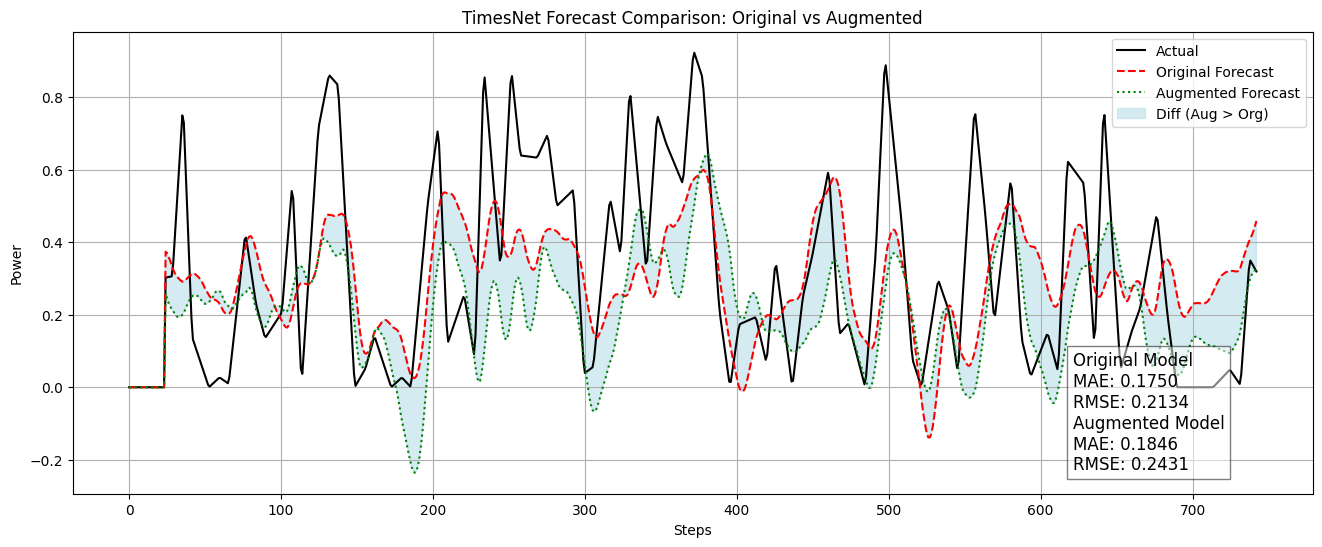

In [70]:
results = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=7991, 
    end_point=8734
)

results_1 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
   start_point=16726, 
   end_point=17469
)

results_2 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=25461, 
    end_point=26204
)

results_3 = evaluate_two_timesnet_models(
    model_org=model_timesnet_org,
    model_aug=model_timesnet_aug,
    X_train_org=X_train_org,
    y_train_org=y_train_org,
    X_test=X_test,
    y_test=y_test,
    input_len=24,
    forecast_len=12,
    start_point=34196, 
    end_point=34939
)